In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.integrate as sp

Define initial information then transform into log basis

In [9]:
# Perform logarithmic transformation on data to make the distribution more 
# uniform this should improve the stability of the solution as final results 
# have a high spread

# Set rate constants
k ={
'1':np.log(1.34),
'2':np.log(1.6e9),
'3':np.log(8e3),
'4':np.log(4e7),
'5':np.log(1)
}
# Set initial concentrations in M, log transform means P0 and Q0 cannot be = 0
initial ={
'A0':0.06,
'B0':0.06,
'P0':1e-99,
'Q0':1e-99,
'X0':10**(-9.8),
'Y0':10**(-6.52),
'Z0':10**(-7.32)
}

i_conc = list(initial.values())
i_conc = np.log(i_conc)

In [35]:
class Cell():
    '''
    '''
    def __init__(self):
        #setting conc values for each component, values are already log(conc)
        self.A = i_conc[0]
        self.B = i_conc[1]
        self.P = i_conc[2]
        self.Q = i_conc[3]
        self.X = i_conc[4]
        self.Y = i_conc[5]
        self.Z = i_conc[6]

    # def dX(self):
    #     dA = -k1*self.A*self.Y
    #     dB = -k3*self.B*self.X
    #     dP = k1*self.A*self.Y +k2*self.X*self.Y
    #     dQ = k4*(self.X)**2
    #     dX = k1*self.A*self.Y -k2*self.X*self.Y +k3*self.B*self.X -k4*(self.X)**2
    #     dY = -k1*self.A*self.Y -k2*self.X*self.Y +k5*self.Z
    #     dZ = k3*self.B*self.X -k5*self.Z
    #     return dA,dB,dP,dQ,dX,dY,dZ
    
    def dXdt(self):
        ### Determine the rates of change for each log value
        # define rates of each reaction
        ln_r1 = k['1'] + self.A + self.Y
        ln_r2 = k['2'] + self.X + self.Y
        ln_r3 = k['3'] + self.B + self.X
        ln_r4 = k['4'] + 2*self.X
        ln_r5 = k['5'] + self.Z

        dA = -np.exp(ln_r1)*np.exp(-self.A)
        dB = -np.exp(ln_r3)*np.exp(-self.B)
        dP = (np.exp(ln_r1)+np.exp(ln_r2))*np.exp(-self.P)
        dQ = np.exp(ln_r4)*np.exp(-self.Q)
        dX = (np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r3)-2*np.exp(ln_r4))*np.exp(-self.X)
        dY = (-np.exp(ln_r1)-np.exp(ln_r2)+np.exp(ln_r5))*np.exp(-self.Y)
        dZ = (np.exp(ln_r3)-np.exp(ln_r5))*np.exp(-self.Z)

        return dA,dB,dP,dQ,dX,dY,dZ

    def timestep(self,dt):
        ### step the ssytem forwards by 1 timestep, length dt
        d = self.dXdt()

        self.A += dt*d[0] 
        self.B += dt*d[1]
        self.P += dt*d[2]
        self.Q += dt*d[3]
        self.X += dt*d[4]
        self.Y += dt*d[5]
        self.Z += dt*d[6]
    
    def determine_step(self,tol):
        max_step=0.01
        

    def run_sim(self,tf):
        ### run a simulation of the system in the range (0,tf)
        n_steps = 0
        t = 0
        x_t = list()
        y_t = list()
        z_t = list()
        t_t = list()

        while t < tf:
            if n_steps%1e4 == 0:
                t_t.append(t)
                x_t.append(self.X)
                y_t.append(self.Y)
                z_t.append(self.Z)

            self.timestep(10e-6)
            n_steps += 1
            t = n_steps*10e-6
        
        return [t_t,x_t,y_t,z_t]
    

In [36]:
c = Cell()

In [37]:
output = c.run_sim(90)

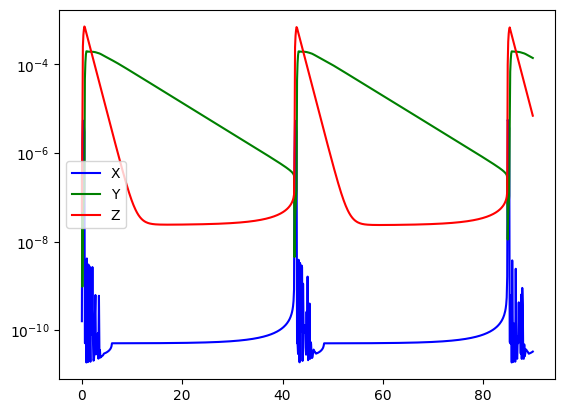

In [38]:
times = output[0]
cX = np.exp(output[1])
cY = np.exp(output[2])
cZ = np.exp(output[3])

# Plot values obtained with sp.solve_ivp()
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
# ax.set_xlim(0,90)
# ax.set_ylim(10e-12,10e-4)

ax.plot(times,cX,label='X',c='blue')
ax.plot(times,cY,label='Y',c='green')
ax.plot(times,cZ,label='Z',c='red')    

plt.legend()

### Solution using scipy

In [280]:
# define scipy input function   
def dX(t,ABPQXYZ):
    A,B,P,Q,X,Y,Z = ABPQXYZ 
    dA = -k1*A*Y
    dB = -k3*B*X
    dP = k1*A*Y +k2*X*Y
    dQ = k4*((X)**2)
    dX = k1*A*Y -k2*X*Y +k3*B*X -2*k4*((X)**2)
    dY = -k1*A*Y -k2*X*Y +k5*Z
    dZ = k3*B*X -k5*Z
    return dA,dB,dP,dQ,dX,dY,dZ

In [214]:
sol = sp.solve_ivp(dX,(0,90),i_conc,method='BDF',max_step=0.0005,first_step=10e-6,t_eval=np.linspace(0,90,150))

In [318]:
res = sp.solve_ivp(dX,(0,90),i_conc,method='Radau',first_step=10e-6,max_step=10e-4,t_eval=np.linspace(0,90,200))

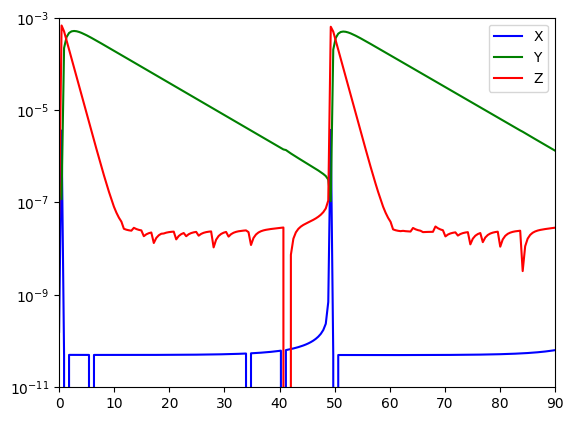

In [319]:
times = res.t
ys = res.y

cX = ys[4]
cY = ys[5]
cZ = ys[6]

# Plot values obtained with sp.solve_ivp()
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
ax.set_xlim(0,90)
ax.set_ylim(10e-12,10e-4)

ax.plot(times,cX,label='X',c='blue')
ax.plot(times,cY,label='Y',c='green')
ax.plot(times,cZ,label='Z',c='red')    

plt.legend()

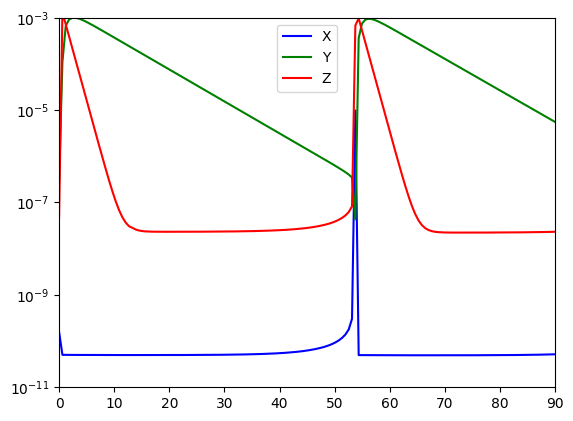

In [219]:
times = sol.t
ys = sol.y

cX = ys[4]
cY = ys[5]
cZ = ys[6]

# Plot values obtained with sp.solve_ivp()
fig = plt.figure()
ax = plt.axes()

ax.set_yscale('log')
ax.set_xlim(0,90)
ax.set_ylim(10e-12,10e-4)

ax.plot(times,cX,label='X',c='blue')
ax.plot(times,cY,label='Y',c='green')
ax.plot(times,cZ,label='Z',c='red')    

plt.legend()